# Prosthetic Sensor Temperature Analysis

### About the data:
Thermocouples and epidermal sensors were placed at 8 location (see Fig. 1). Data contains 8 feature rows and a class label. 

Important Notes:
- Sensor data is inherently noisy, as such, using a denoising autoencoder (dA) might be necessary. dA uses input $x \in [0,1]^d$ and maps it to $ y \in [0,1]^d$, uing a deterministic mapping often levered by a sigmoid function ($s$): $y=s(Wx+b)$ 
- Here, we will employ bidirectional LSTM (BLSTM), which are capable of learning the context in both temporal directions, in addition to a multi-layer perceptron (MLP), stacked (Model 1)
- **Future Implementation**: Auxiliary Classifier Generative Adversarial Network (ACGAN) is also shown in Model 2
- As evaluation metrics we used F-measure in order to compare the results with previous works.
![Fig.1](data/SCH-sensors.png) 
Fig. 1 Sensor Placement

[MCH]

In [1]:
""" Packages and Necessary Libraries
    
"""
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

# DL Framework
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, LSTM, Dense, Flatten, Activation
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import optimizers
from keras.models import model_from_json
from keras import backend as K
K.set_image_dim_ordering('th')

# Graphics and others
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os, operator
import time

# Random Seed for reproducibiltiy
seed = 7
np.random.seed(seed)


Using Theano backend.


Imported dataset shape =  (18, 25) (subjects, 24 features + class)


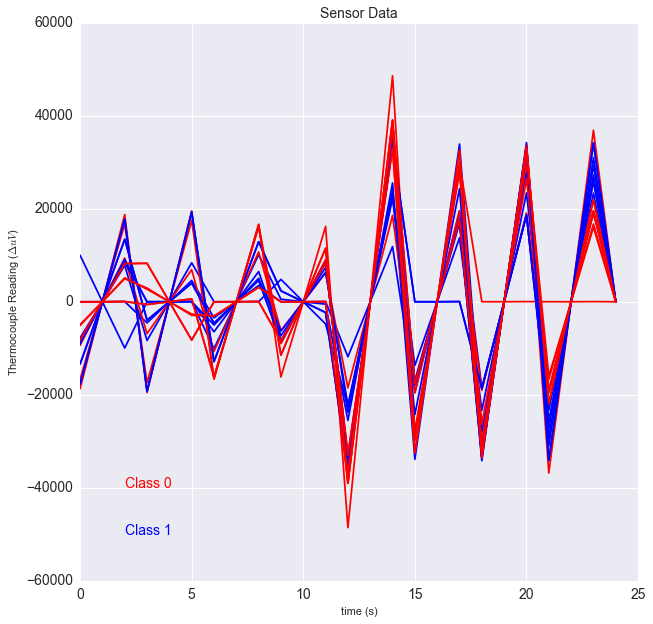

In [2]:
#=================================================#
#   Data Loading                                  #
#=================================================#
# Previously: 8 feature rows  (plus an additional 1 for class label) and 12 columns (subjects).
# Now:        24 feature rows (plus an additional 1 for class label) and 15 columns.

dataset = ((pd.read_csv('data/DataPoints2.csv', 
                        header=None)).values).T
print('Imported dataset shape = ', dataset.shape ,
      '(subjects, 24 features + class)')

# Visualize dataset
plt.figure(figsize=(10,10))
for i in range(0,dataset.shape[0]):
    if dataset[i,-1]==0: 
        cr = 'r'; cl = 0
    else:
        cr = 'b'; cl = 1
    plt.plot(dataset[i,:], color=cr, label=cl)
plt.title("Sensor Data", fontsize=14)
plt.text(2,-40000, 'Class 0', color='red', fontsize=14)
plt.text(2,-50000, 'Class 1', color='blue', fontsize=14)
plt.ylabel('Thermocouple Reading ($\Delta uV$)')
plt.xlabel('time (s)')
plt.xticks(fontsize=14);plt.yticks(fontsize=14);plt.show()


In [20]:
#=================================================#
#   Training parameters                           #
#=================================================#
l = 1e-6
num_classes = 2
num_epochs = 100
num_batches = 16
num_hidden = 50
sgd = optimizers.SGD(lr=l)


In [21]:
#=================================================#
#   Data Formatting for Training                  #
#=================================================#
''' 
Set up data for training and testing
Ideally would have enough data to make it 60% training, 30% testing, 10% validation
'''
np.random.shuffle(dataset)
def create_dataset(dataset):
    train_size = int(len(dataset) * 0.7)
    train, test = dataset[0:train_size], dataset[(train_size+1):]
    return np.array(train), np.array(test)

x_train,x_test = create_dataset(dataset[:,:-1])
y_train,y_test = create_dataset(dataset[:,-1])

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train.astype(int),num_classes)
y_test = to_categorical(y_test.astype(int), num_classes)

print('Train and testing data shape:', x_train.shape,x_test.shape)

Train and testing data shape: (12, 24) (5, 24)


In [22]:
#=================================================#
#   Multi Layer Perceptron (MLP)                  #
#=================================================#

# Callback for later analysis
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.predictions = []
        self.i = 0
        self.save_every = 100

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(x_train)
            self.predictions.append(pred)
            
history = TrainingHistory()

#Modify dataset to fit BLSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
input_dim = x_train.shape[1]

# Define Model
model = Sequential()

# Model
model.add(Bidirectional(LSTM(num_hidden,return_sequences=True),input_shape=(x_train.shape[1],1)))
model.add(TimeDistributed(Dense(x_train.shape[1]), name='Dense_layer')) #keeps 3D output after Dense
model.add(Flatten())
model.add(Dense(num_hidden, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_hidden, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

MLP = model.fit(x_train, y_train, 
                batch_size=num_batches, 
                verbose=1, 
                nb_epoch=num_epochs,
                callbacks=[history])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
bidirectional_2 (Bidirectional)  (None, 24, 100)       20800       bidirectional_input_2[0][0]      
____________________________________________________________________________________________________
Dense_layer (TimeDistributed)    (None, 24, 24)        2424        bidirectional_2[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 576)           0           Dense_layer[0][0]                
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 50)            28850       flatten_2[0][0]                  
___________________________________________________________________________________________

12/12 [==============================] - 0s - loss: 0.0502 - acc: 1.0000
Epoch 73/100
12/12 [==============================] - 0s - loss: 0.0791 - acc: 1.0000
Epoch 74/100
12/12 [==============================] - 0s - loss: 0.1171 - acc: 0.9167
Epoch 75/100
12/12 [==============================] - 0s - loss: 0.1679 - acc: 0.8333
Epoch 76/100
12/12 [==============================] - 0s - loss: 0.0565 - acc: 1.0000
Epoch 77/100
12/12 [==============================] - 0s - loss: 0.0689 - acc: 1.0000
Epoch 78/100
12/12 [==============================] - 0s - loss: 0.0540 - acc: 1.0000
Epoch 79/100
12/12 [==============================] - 0s - loss: 0.0252 - acc: 1.0000
Epoch 80/100
12/12 [==============================] - 0s - loss: 0.0274 - acc: 1.0000
Epoch 81/100
12/12 [==============================] - 0s - loss: 0.0259 - acc: 1.0000
Epoch 82/100
12/12 [==============================] - 0s - loss: 0.0122 - acc: 1.0000
Epoch 83/100
12/12 [==============================] - 0s - loss: 0.

5/5 [==============================] - 0s
Test loss: 0.00319016980939
Test accuracy: 1.0


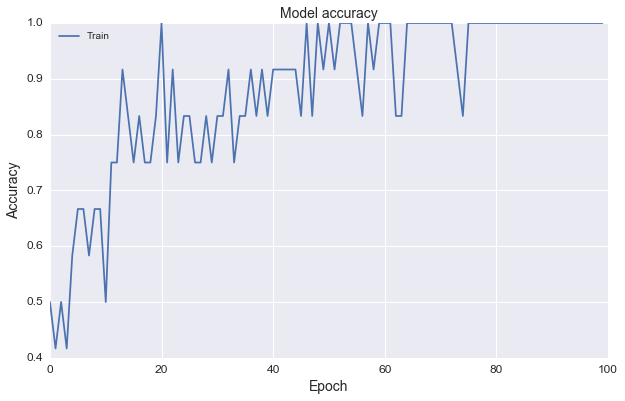

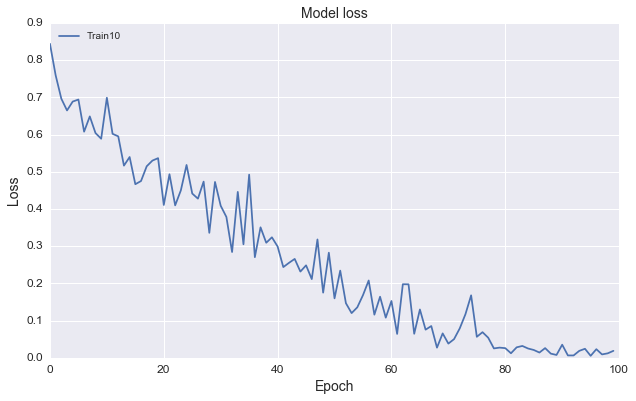

5/5 [==============================] - 0s


In [23]:
#=================================================#
#   Pos-training Evaluation                       #
#=================================================#

# Score Training
score = model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Summarize history for accuracy
plt.figure(figsize=(10,6))
plt.plot(MLP.history['acc'])
plt.title('Model accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Test'], loc='upper left')
plt.xticks(fontsize=12);plt.yticks(fontsize=12);plt.show()

# Loss
plt.figure(figsize=(10.2,6))
plt.plot(MLP.history['loss'])
plt.title('Model loss', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train10', 'Test'], loc='upper left')
plt.xticks(fontsize=12);plt.yticks(fontsize=12);plt.show()
# Predictions
MLP_class_pred = model.predict_classes(x_test,batch_size=num_batches, verbose=1)
MLP_probs = model.predict_proba(x_test,batch_size=num_batches, verbose=1)


Testing MLP Shannon Entropy Average: 0.0297774909108 +/- 0.00029787129773


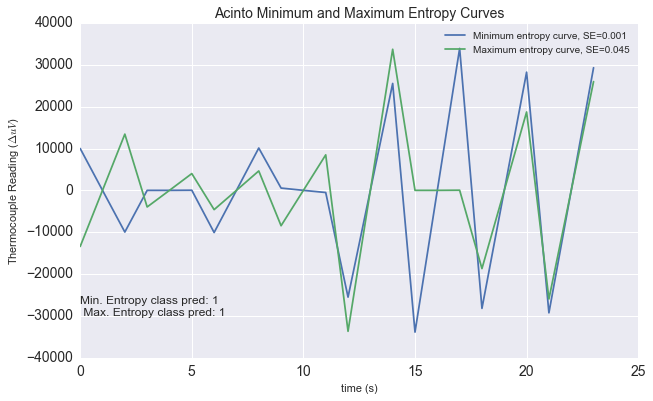

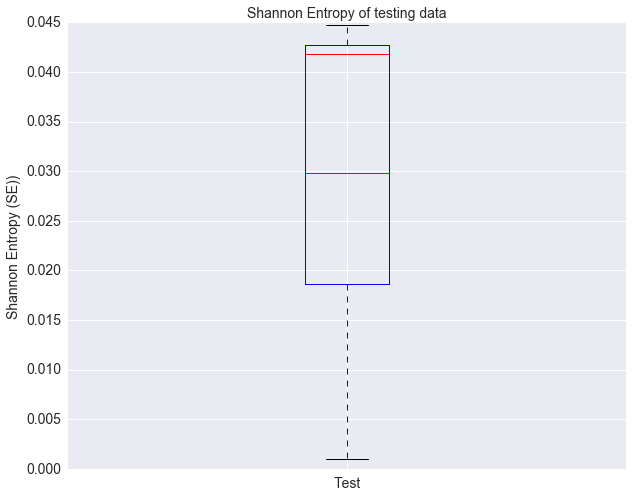

In [24]:
#=================================================#
#   Shannon Entropy                               #
#=================================================#
SE_test = np.array( [-sum([i*np.log2(i) for i in row if i!=0.0]) for row in MLP_probs] )
print("Testing MLP Shannon Entropy Average:", np.average(SE_test), "+/-", np.var(SE_test))

# Find max min of acinto4
plt.figure(figsize=(10,6))
index_min = np.argmin(SE_test); index_max = np.argmax(SE_test)
plt.plot(x_test[index_min,:], label='Minimum entropy curve, SE=%.3f'%SE_test[index_min].astype('float32')); 
plt.plot(x_test[index_max,:], label='Maximum entropy curve, SE=%.3f'%SE_test[index_max].astype('float32')); 
plt.legend(); plt.title("Acinto Minimum and Maximum Entropy Curves", fontsize=14);
plt.text( 0,-30000,'Min. Entropy class pred: %1.0f \n Max. Entropy class pred: %1.0f'%(MLP_class_pred[index_min],
                                                                                       MLP_class_pred[index_max]))
plt.ylabel('Thermocouple Reading ($\Delta uV$)')
plt.xlabel('time (s)')
plt.xticks(fontsize=14);plt.yticks(fontsize=14);plt.show()


# Boxplots
plt.figure(figsize=(10,8))
plt.boxplot([SE_test],  notch=0, sym='+', vert=1, whis=1.5, showmeans=True, meanline=True)
plt.xticks([1],['Test'])
plt.title('Shannon Entropy of testing data', fontsize=14)
plt.ylabel('Shannon Entropy (SE))', fontsize=14)
plt.xticks(fontsize=14);plt.yticks(fontsize=14);plt.show()

In [25]:
#=================================================#
#   Predictions                                   #
#=================================================#
from sklearn.metrics import f1_score

preds = to_categorical(MLP_class_pred, num_classes)
print("Test predictions: \n", preds)
print('Original Data: \n', y_test)
print('Number of matches:', (preds==y_test).sum()/(2), 'out of', y_test.shape[0])

print('\nF1 score [class0,class1]:' , f1_score(y_test,preds,average=None))

Test predictions: 
 [[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Original Data: 
 [[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Number of matches: 5 out of 5

F1 score [class0,class1]: [ 1.  1.]


Validation dataset sucessful
Confusion matrix, without normalization
[[2 0]
 [0 3]]


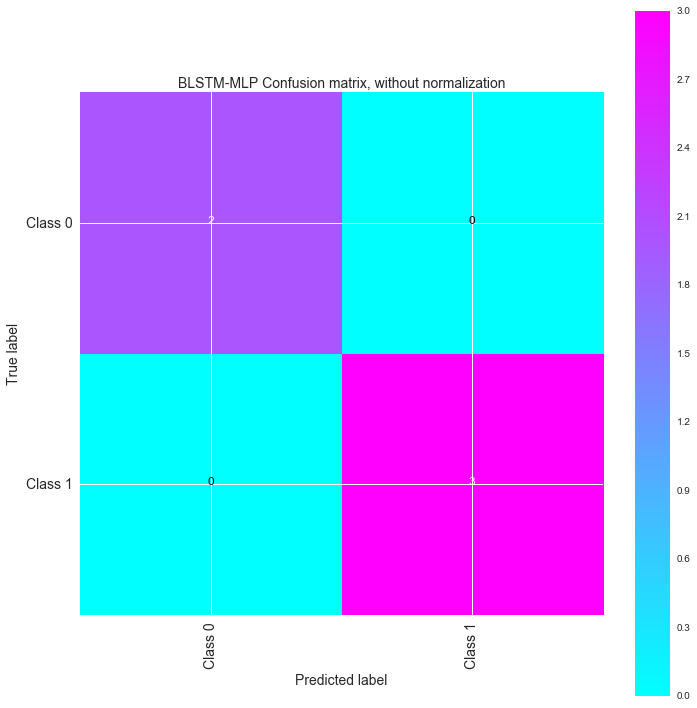

In [26]:
#=================================================#
#   Confusion Matrix                              #
#=================================================#
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    

#=================================================#
# Compute confusion matrix
# Non-categorical dataset
y_train,y_test = create_dataset(dataset[:,-1])
print("Validation dataset sucessful")

cnf_matrix = confusion_matrix(y_test,MLP_class_pred)
np.set_printoptions(precision=2)

class_names = ['Class 0','Class 1']

plt.figure()
fig = plt.gcf()
fig.set_size_inches(10,10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='BLSTM-MLP Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.xticks(fontsize=14);plt.yticks(fontsize=14);plt.show()

CI MLP:  0.0 +/- [0.0]
CI MLP:  0.0 +/- [0.0]
Correct per class  [Class 0, Class 1]: [ 2.  3.] 
Incorrect per class  [Class 0, Class 1]: [ 0.  0.]

Accuracy [Class 0, Class 1]: [ 100.  100.] %


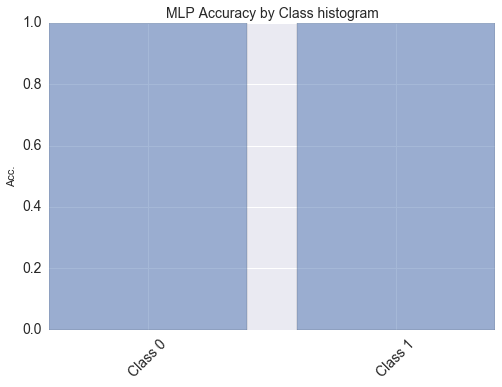

In [27]:
#=================================================#
#   Confidence Interval                           #
#=================================================#
'''
    Calculates the confidence interval of the model based on the Wilson Score Interval 
    Observations in the validation data set were drawn from the domain independently (e.g. they are independent and identically distributed).
    At least 30 observations were used to evaluate the model.
'''
const = 1.96 #(95%)
class_accuracies = np.zeros((num_classes)) #correct/total
class_errors =  np.zeros((num_classes))  #incorrect/total
corrects = np.zeros((num_classes)).astype('float32')
incorrects = np.zeros((num_classes)).astype('float32')
performance =np.arange(0,num_classes)

# MLP
fig, ax = plt.subplots()  
for (pred, actual) in zip(MLP_class_pred, y_test.astype('int')):
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

for i in range (0,num_classes):
    class_accuracies[i] = corrects[i]/(corrects[i]+incorrects[i])
    class_error = incorrects[i]/(corrects[i]+incorrects[i])
    CI_MLP = [const * np.sqrt( (class_error * (1 - class_error)) / y_test.shape[0])]
    print("CI MLP: ", class_error, "+/-", CI_MLP)   

print("Correct per class  [Class 0, Class 1]:", corrects, "\nIncorrect per class  [Class 0, Class 1]:" , incorrects) 
print("\nAccuracy [Class 0, Class 1]:",class_accuracies*100, '%')
   

ax.bar(performance,class_accuracies, align='center', alpha=0.5);
# plt.figure(figsize=(10,10))
plt.xticks(np.arange(0,num_classes), class_names, rotation=45);
plt.ylabel('Acc.');
plt.title('MLP Accuracy by Class histogram', fontsize=14)
plt.xticks(fontsize=14);plt.yticks(fontsize=14);plt.show()
